**THIS CODE IS FOR APPLYING BASIC NLP AND PRETRAINED MODELS LIKE VADER TO PERFORM SENTIMENT ANALYSIS**

In [1]:
%pip install seaborn
%pip install nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


C:\Users\hp\AppData\Local\Temp\ipykernel_16728\3157720793.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('i9_g12_final.csv') #INSERT FILENAME HERE
print(df.shape)
df = df.head(500)
print(df.shape)

(177, 5)
(177, 5)


**GETTING THE AMOUNT OF REVIEWS IN EACH CATEGORY**

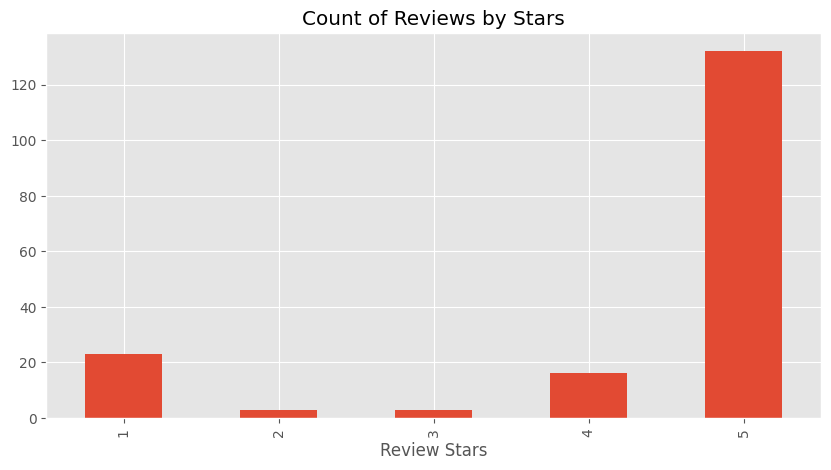

In [3]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

BASIC NLTK

In [4]:
example = df['review'][50]
print(example)
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
tokens = nltk.word_tokenize(example)
tokens[:10]

This CPU is top quality, it is easy to install and works great for gaming, it stays cool and I have had no problems with it.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


['This', 'CPU', 'is', 'top', 'quality', ',', 'it', 'is', 'easy', 'to']

In [5]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('CPU', 'NNP'),
 ('is', 'VBZ'),
 ('top', 'JJ'),
 ('quality', 'NN'),
 (',', ','),
 ('it', 'PRP'),
 ('is', 'VBZ'),
 ('easy', 'JJ'),
 ('to', 'TO')]

**USAGE OF VADER MODEL HERE**

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
# Run the polarity score on the entire dataset
%pip install --upgrade tqdm
from tqdm.notebook import tqdm

res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review']
    myid = row['no.']
    try:
      res[myid] = sia.polarity_scores(text)
    except:
      pass


Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/177 [00:00<?, ?it/s]

In [8]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'no.'})
vaders = vaders.merge(df, how='left')

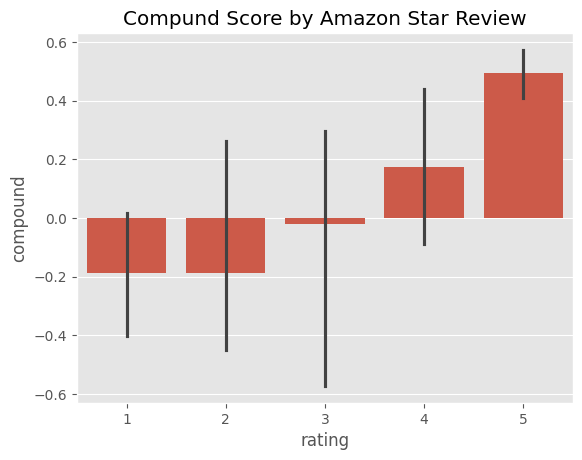

In [9]:
ax = sns.barplot(data=vaders, x='rating', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

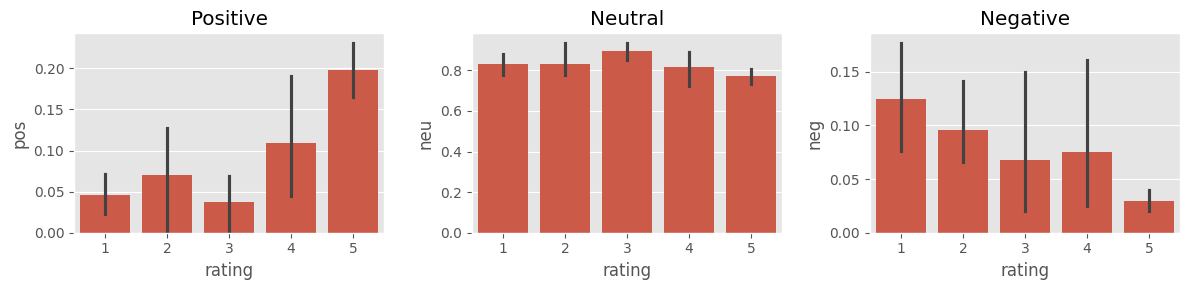

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [11]:
%pip install transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

Note: you may need to restart the kernel to use updated packages.


**USAGE OF ROBERTA MODEL FOR SENTIMENT ANALYSIS**

In [12]:
%pip install torch torchvision torchaudio
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Note: you may need to restart the kernel to use updated packages.


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**RUNNING THE ROBERTA MODEL AND GETTING THE SCORES**

In [13]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.007879448, 'roberta_neu': 0.030633755, 'roberta_pos': 0.9614868}


In [14]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [15]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['review']
        myid = row['no.']
        try:
          vader_result = sia.polarity_scores(text)
        except:
          pass
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        try:
          roberta_result = polarity_scores_roberta(text)
        except:
          pass
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/177 [00:00<?, ?it/s]

In [16]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'no.'})
results_df = results_df.merge(df, how='left')


PLOTTING THE ROBERTA AND VADER MODEL IN GRAPHS

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


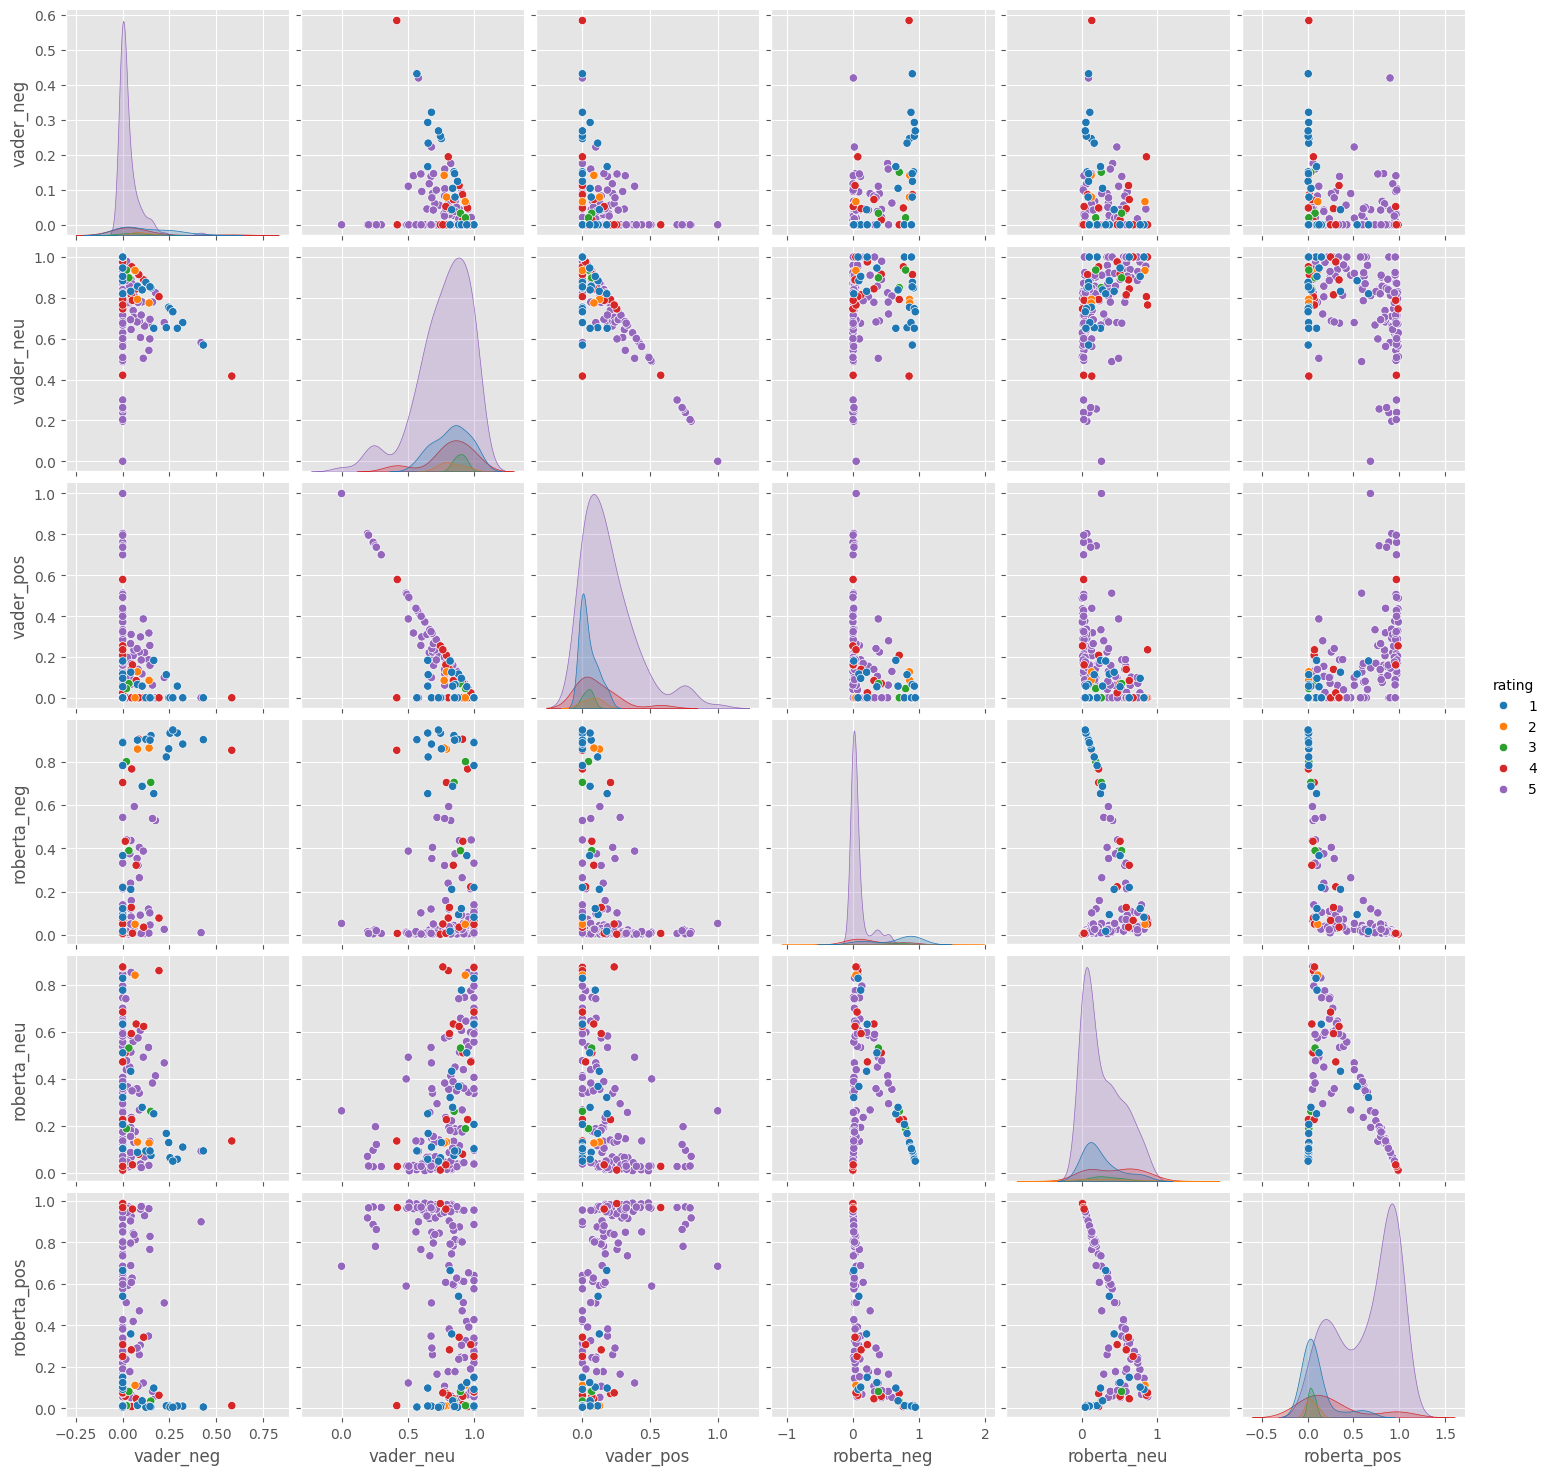

In [17]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='rating',
            palette='tab10')
plt.show()

**SENTIMENT ANALYSIS USING PIPELINE**

In [2]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


EXAMPLE FOR THE WORKING OF PIPELINE SENTIMENT ANALYSIS

In [3]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

USING THE OUTPUT.TXT FILE IN WHICH ALL THE REVIEWS ARE STORED TO PERFORM THE ANALYSIS AND GET THE SCORES

In [22]:
import time
with open('output.txt', 'r') as f:
  text = f.read()

chunk_size = 800
chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

results = []

for chunk in chunks:
  try:
    x=sent_pipeline(f"{chunk}")
    results.append(x)
  except Exception as e:
    print(e)
    time.sleep(61)



In [23]:
print(results)


[[{'label': 'POSITIVE', 'score': 0.9872574210166931}], [{'label': 'POSITIVE', 'score': 0.9883821606636047}], [{'label': 'NEGATIVE', 'score': 0.9989126920700073}], [{'label': 'NEGATIVE', 'score': 0.9984036087989807}], [{'label': 'NEGATIVE', 'score': 0.9992426633834839}], [{'label': 'NEGATIVE', 'score': 0.9990578293800354}], [{'label': 'NEGATIVE', 'score': 0.9992260932922363}], [{'label': 'NEGATIVE', 'score': 0.9919558763504028}], [{'label': 'NEGATIVE', 'score': 0.99925297498703}], [{'label': 'NEGATIVE', 'score': 0.998085618019104}], [{'label': 'NEGATIVE', 'score': 0.9990838766098022}], [{'label': 'NEGATIVE', 'score': 0.9989932179450989}], [{'label': 'NEGATIVE', 'score': 0.9994494318962097}], [{'label': 'NEGATIVE', 'score': 0.9916343688964844}], [{'label': 'NEGATIVE', 'score': 0.9717531800270081}], [{'label': 'NEGATIVE', 'score': 0.9993199110031128}], [{'label': 'NEGATIVE', 'score': 0.9984126091003418}], [{'label': 'POSITIVE', 'score': 0.5032172799110413}], [{'label': 'POSITIVE', 'score'

**CALCULATING THE PERCENTAGE OF POSITIVE AND NEAGTIVE SENTIMENTS USING THE RESULTS**

In [25]:
total_sum = 0
pos_sum = 0
neg_sum = 0
for item in results:
    for record in item:
        score = record['score']
        label = record['label']
        total_sum += score
        if label == 'POSITIVE':
            pos_sum += score
        elif label == 'NEGATIVE':
            neg_sum += score

# Calculate percentages
pos_percentage = (pos_sum / total_sum) * 100
neg_percentage = (neg_sum / total_sum) * 100

# Print the results
print(f"Total Sum: {total_sum}")
print(f"Positive Sum: {pos_sum}")
print(f"Negative Sum: {neg_sum}")
print(f"The percentage of POSITIVE sentiment in the reviews: {pos_percentage}%")
print(f"The percentage of NEGATIVE sentiment in the reviews : {neg_percentage}%")

Total Sum: 33.591016352176666
Positive Sum: 11.860888719558716
Negative Sum: 21.73012763261795
The percentage of POSITIVE sentiment in the reviews: 35.309704818711566%
The percentage of NEGATIVE sentiment in the reviews : 64.69029518128842%
